In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


In [5]:
df = pd.read_csv("../data/processed.csv")
df.head()


,id,label,source,url,published_at,title,summary,text,scraped_at
0,59aa47affa6cf03b40dc1ea2bf1cc596859b4e2c,world,www.bbc.com,https://www.bbc.com/news/articles/cg7y0579lp8o...,2026-01-08 20:18:36+00:00,Huge anti-government protests in Tehran and ot...,Rallies on major roads in the capital and in I...,Videos posted on social media show large crowd...,2026-01-08 21:16:49.797836+00:00
1,2e0f1522c9f4cec1c13465bcdadbba04bd1e4f53,world,www.bbc.com,https://www.bbc.com/news/articles/c2lgjd51v95o...,2026-01-08 15:18:14+00:00,Vance criticises Denmark and Europe's handling...,European allies of Denmark have rejected Trump...,"US Vice-President JD Vance says Greenland is ""...",2026-01-08 21:16:51.371044+00:00
2,c6d64b8a09611b67eeb29fa60813e2505b47e3b4,world,www.bbc.com,https://www.bbc.com/news/articles/cp80ln97py5o...,2026-01-08 16:03:11+00:00,Trump withdraws US from key climate treaty and...,The White House says the decision was taken be...,US President Donald Trump has withdrawn the US...,2026-01-08 21:16:52.957906+00:00
3,8e24eb16b989c59c8c11b3d9d36f022a918dd073,world,www.bbc.com,https://www.bbc.com/news/articles/ckgl8jgdxypo...,2026-01-08 11:01:19+00:00,Influential China church reports arrests as cr...,Leaders of Early Rain Covenant Church have bee...,An influential Protestant church in China says...,2026-01-08 21:16:54.473772+00:00
4,1b472311768c350328f378092980a79857428069,world,www.bbc.com,https://www.bbc.com/sport/tennis/articles/cx2g...,2026-01-08 16:28:22+00:00,Tennis Kenya admits it shouldn't have let amat...,The organisers of a professional women's tourn...,Hajar Abdelkader's biography on the ITF websit...,2026-01-08 21:16:56.323144+00:00


In [6]:
df['label'].value_counts()


label
business    656
world       650
health      646
science     643
tech        623
Name: count, dtype: int64

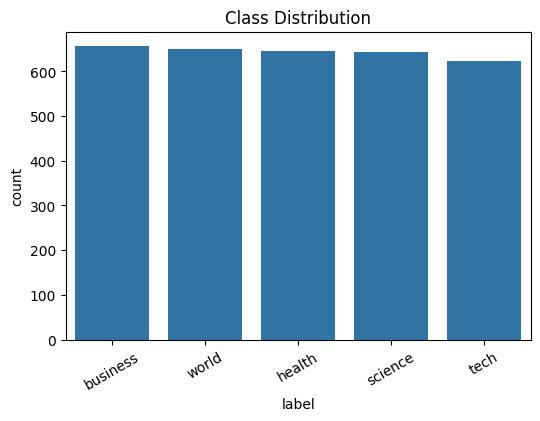

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title("Class Distribution")
plt.xticks(rotation=30)
plt.show()


In [8]:
df['text_len'] = df['text'].apply(lambda x: len(x.split()))

df['text_len'].describe()


count    3218.000000
mean      136.895898
std       330.766160
min         7.000000
25%        25.000000
50%        29.000000
75%        37.000000
max      3535.000000
Name: text_len, dtype: float64

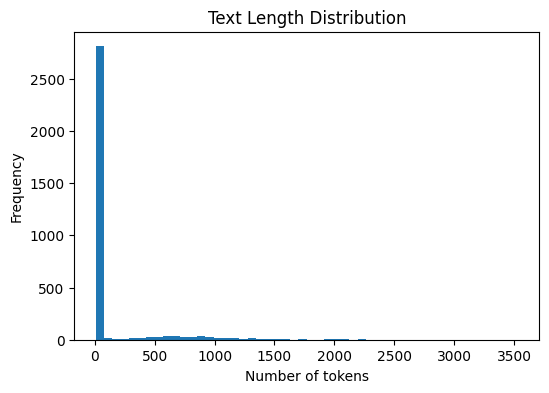

In [9]:
plt.figure(figsize=(6,4))
plt.hist(df['text_len'], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Number of tokens")
plt.ylabel("Frequency")
plt.show()


In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in ENGLISH_STOP_WORDS and len(t) > 2]
    return " ".join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)
df[['text','clean_text']].head()


,text,clean_text
0,Videos posted on social media show large crowd...,videos posted social media large crowds protes...
1,"US Vice-President JD Vance says Greenland is ""...",vice president vance says greenland critical d...
2,US President Donald Trump has withdrawn the US...,president donald trump withdrawn dozens intern...
3,An influential Protestant church in China says...,influential protestant church china says promi...
4,Hajar Abdelkader's biography on the ITF websit...,hajar abdelkader biography itf website says st...


In [12]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 2574
Test size: 644


In [13]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


In [14]:
bow = CountVectorizer(
    ngram_range=(1,2),
    max_features=60000,
    min_df=2
)

Xtr_bow = bow.fit_transform(X_train)
Xte_bow = bow.transform(X_test)

lr_bow = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    n_jobs=None
)

lr_bow.fit(Xtr_bow, y_train)
pred_lr_bow = lr_bow.predict(Xte_bow)

print("BoW + Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr_bow))
print(classification_report(y_test, pred_lr_bow))


BoW + Logistic Regression Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

    business       0.94      0.92      0.93       131
      health       0.89      0.93      0.91       129
     science       0.89      0.91      0.90       129
        tech       0.92      0.92      0.92       125
       world       0.92      0.88      0.90       130

    accuracy                           0.91       644
   macro avg       0.91      0.91      0.91       644
weighted avg       0.91      0.91      0.91       644



In [15]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=60000,
    min_df=2,
    sublinear_tf=True
)

Xtr_tfidf = tfidf.fit_transform(X_train)
Xte_tfidf = tfidf.transform(X_test)

lr_tfidf = LogisticRegression(
    max_iter=2000,
    class_weight="balanced"
)

lr_tfidf.fit(Xtr_tfidf, y_train)
pred_lr_tfidf = lr_tfidf.predict(Xte_tfidf)

print("TF-IDF + Logistic Regression Accuracy:", accuracy_score(y_test, pred_lr_tfidf))
print(classification_report(y_test, pred_lr_tfidf))


TF-IDF + Logistic Regression Accuracy: 0.9161490683229814
              precision    recall  f1-score   support

    business       0.94      0.90      0.92       131
      health       0.89      0.97      0.93       129
     science       0.91      0.93      0.92       129
        tech       0.97      0.90      0.93       125
       world       0.88      0.88      0.88       130

    accuracy                           0.92       644
   macro avg       0.92      0.92      0.92       644
weighted avg       0.92      0.92      0.92       644



In [16]:
svm_tfidf = LinearSVC(class_weight="balanced")

svm_tfidf.fit(Xtr_tfidf, y_train)
pred_svm_tfidf = svm_tfidf.predict(Xte_tfidf)

print("TF-IDF + Linear SVM Accuracy:", accuracy_score(y_test, pred_svm_tfidf))
print(classification_report(y_test, pred_svm_tfidf))


TF-IDF + Linear SVM Accuracy: 0.9332298136645962
              precision    recall  f1-score   support

    business       0.97      0.91      0.94       131
      health       0.90      0.96      0.93       129
     science       0.92      0.92      0.92       129
        tech       0.94      0.95      0.94       125
       world       0.94      0.92      0.93       130

    accuracy                           0.93       644
   macro avg       0.93      0.93      0.93       644
weighted avg       0.93      0.93      0.93       644



In [17]:
best_pred = pred_svm_tfidf  # gerekirse pred_lr_tfidf yap
labels = sorted(df['label'].unique())

cm = confusion_matrix(y_test, best_pred, labels=labels)

print("Labels order:", labels)
print(cm)


Labels order: ['business', 'health', 'science', 'tech', 'world']
[[119   3   3   1   5]
 [  0 124   4   1   0]
 [  0   6 119   3   1]
 [  1   3   1 119   1]
 [  3   2   2   3 120]]


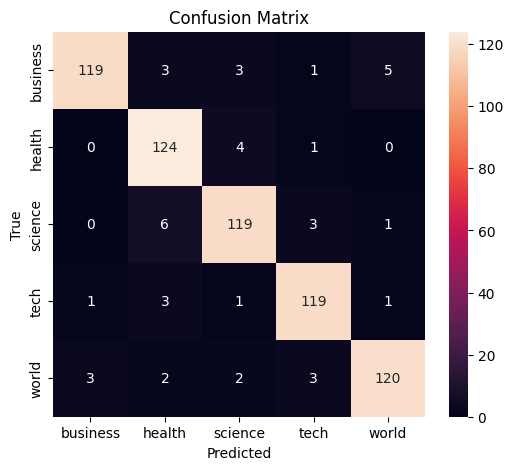

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping


In [20]:
MAX_VOCAB = 30000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

Xtr_seq = tokenizer.texts_to_sequences(X_train)
Xte_seq = tokenizer.texts_to_sequences(X_test)

Xtr_pad = pad_sequences(Xtr_seq, maxlen=MAX_LEN, padding="post", truncating="post")
Xte_pad = pad_sequences(Xte_seq, maxlen=MAX_LEN, padding="post", truncating="post")

Xtr_pad.shape, Xte_pad.shape


((2574, 300), (644, 300))

In [21]:
label_index = {l:i for i,l in enumerate(sorted(y.unique()))}
index_label = {i:l for l,i in label_index.items()}

ytr_enc = y_train.map(label_index).values
yte_enc = y_test.map(label_index).values


In [22]:
model = Sequential([
    Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
    GlobalAveragePooling1D(),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(label_index), activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


c:\Users\usama\OneDrive\Masaüstü\learning-from-data-final\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    Xtr_pad, ytr_enc,
    validation_split=0.1,
    epochs=15,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.2103 - loss: 1.6133 - val_accuracy: 0.1860 - val_loss: 1.6164
Epoch 2/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.2435 - loss: 1.6087 - val_accuracy: 0.2791 - val_loss: 1.5989
Epoch 3/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.2768 - loss: 1.5984 - val_accuracy: 0.5000 - val_loss: 1.5959
Epoch 4/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.2755 - loss: 1.5908 - val_accuracy: 0.2209 - val_loss: 1.6058
Epoch 5/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.3014 - loss: 1.5641 - val_accuracy: 0.2597 - val_loss: 1.5817
Epoch 6/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3169 - loss: 1.5501 - val_accuracy: 0.3760 - val_loss: 1.5375
Epoch 7/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.3756 - loss: 1.4772 - val_accuracy: 0.4767 - val_loss: 1.4477
Epoch 8/15
73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.4547 - loss: 1.3702 - val_accuracy: 0.3605 - v

In [24]:
loss, acc = model.evaluate(Xte_pad, yte_enc)
print("Deep Learning Test Accuracy:", acc)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8835 - loss: 0.5112 
Deep Learning Test Accuracy: 0.8835403919219971


In [25]:
y_pred_dl = model.predict(Xte_pad).argmax(axis=1)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


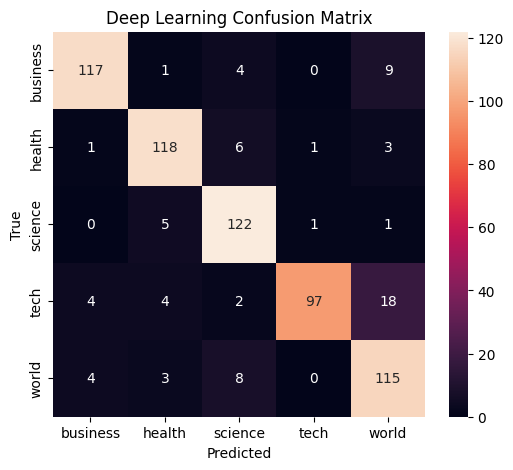

In [26]:
from sklearn.metrics import confusion_matrix

cm_dl = confusion_matrix(yte_enc, y_pred_dl)

plt.figure(figsize=(6,5))
sns.heatmap(cm_dl, annot=True, fmt="d",
            xticklabels=index_label.values(),
            yticklabels=index_label.values())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Deep Learning Confusion Matrix")
plt.show()


In [27]:
import numpy as np
import pandas as pd
import re

def custom_features(texts):
    feats = []
    for t in texts:
        t = t or ""
        tokens = t.split()
        n_tokens = len(tokens)
        n_chars = len(t)
        n_digits = sum(ch.isdigit() for ch in t)
        n_upper = sum(ch.isupper() for ch in t)
        n_excl = t.count("!")
        n_q = t.count("?")
        # basit keyword skorları (domain knowledge)
        business_kw = len(re.findall(r"\b(stock|market|inflation|bank|interest|gdp|trade)\b", t.lower()))
        tech_kw = len(re.findall(r"\b(ai|software|cyber|cloud|chip|startup)\b", t.lower()))
        health_kw = len(re.findall(r"\b(vaccine|disease|hospital|health|clinic|who)\b", t.lower()))
        science_kw = len(re.findall(r"\b(climate|research|space|nasa|study|scientists)\b", t.lower()))
        world_kw = len(re.findall(r"\b(election|war|conflict|sanction|diplomacy|government)\b", t.lower()))
        feats.append([n_tokens, n_chars, n_digits, n_upper, n_excl, n_q,
                      business_kw, tech_kw, health_kw, science_kw, world_kw])
    return np.array(feats, dtype=float)

Xtr_cust = custom_features(X_train)
Xte_cust = custom_features(X_test)

Xtr_cust.shape, Xte_cust.shape


((2574, 11), (644, 11))

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

cust_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

cust_lr.fit(Xtr_cust, y_train)
pred_cust = cust_lr.predict(Xte_cust)

print("Custom-features + LR Accuracy:", accuracy_score(y_test, pred_cust))
print(classification_report(y_test, pred_cust))


Custom-features + LR Accuracy: 0.6164596273291926
              precision    recall  f1-score   support

    business       0.81      0.50      0.62       131
      health       0.88      0.68      0.77       129
     science       0.78      0.70      0.73       129
        tech       0.80      0.34      0.48       125
       world       0.38      0.85      0.52       130

    accuracy                           0.62       644
   macro avg       0.73      0.61      0.63       644
weighted avg       0.73      0.62      0.63       644



In [29]:
results = []

def add_result(name, y_true, y_pred):
    from sklearn.metrics import f1_score
    results.append({
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
    })

add_result("BoW + Logistic Regression", y_test, pred_lr_bow)
add_result("TF-IDF + Logistic Regression", y_test, pred_lr_tfidf)
add_result("TF-IDF + Linear SVM", y_test, pred_svm_tfidf)
add_result("Custom Features + Logistic Regression", y_test, pred_cust)

# Deep learning (yte_enc -> label'e geri çevir)
y_pred_dl_labels = pd.Series(y_pred_dl).map(index_label).values
add_result("Deep Learning (Embedding + MLP)", y_test, y_pred_dl_labels)

pd.DataFrame(results).sort_values("f1_macro", ascending=False)


,model,accuracy,f1_macro,f1_weighted
2,TF-IDF + Linear SVM,0.933230,0.933325,0.933268
1,TF-IDF + Logistic Regression,0.916149,0.916380,0.916237
0,BoW + Logistic Regression,0.913043,0.913100,0.913093
4,Deep Learning (Embedding + MLP),0.883540,0.883594,0.883709
3,Custom Features + Logistic Regression,0.616460,0.625287,0.626015


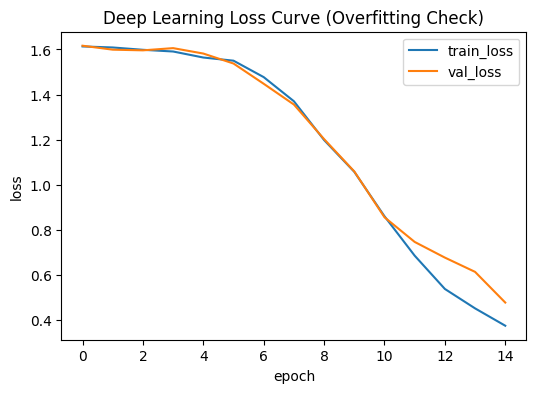

In [30]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Deep Learning Loss Curve (Overfitting Check)")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()
